# Анализ результатов А/В теста

**Легенда:** туристическая фирма разработала 2 варианта посадочной страницы, необходимо выяснить какая из страниц приносит больше прибыли.

Формализованные задачи:
- обработка данных и анализ датасета
- расчет кумулятивных метрик
- проверка гипотез

### Обработка и анализ датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st

In [2]:
df = pd.read_csv('ab_data.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [3]:
# Выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Узнаем сроки проведения теста
df['date'].describe()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16328\2843766816.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                  294478
unique                     23
top       2021-01-08 00:00:00
freq                    13564
first     2021-01-02 00:00:00
last      2021-01-24 00:00:00
Name: date, dtype: object

Тест проводился со 2 по 24 января 2021 г

In [6]:
# Проверим корректность распределения трафика по группам
a_count = len(df[df['group'] == 'A'])
b_count = len(df[df['group'] == 'B'])
relation = (a_count/b_count)*100
relation

99.94975420299302

Разница 0.05%. Распределение сработало корректно. Продолжаем тест, так как разница не превышает 1%.

In [7]:
# Проверим пересечение групп 
# Найдем пользователей попавших в обе группы
group_a = set(df[df['group'] == 'A']['user_id'].values)
group_b = set(df[df['group'] == 'B']['user_id'].values)
list_id = list(group_a & group_b)
print(f'{len(list_id)} пользователей содержатся в обеих группах одновременно.')

1895 пользователей содержатся в обеих группах одновременно.


Так как мы не можем определить какая из версий сайта повлияла на принятие ими решения, исключим этих пользователей.

In [8]:
# Оставим только пользователей, которые не входят в список list_id
df = df[~df['user_id'].isin(list_id)]
print(len(df[df['group'] == 'A']))
print(len(df[df['group'] == 'B']))
# Проверим как изменилось соотношение пользователей в группах после очистки
print(len(df[df['group'] == 'A']) / len(df[df['group'] == 'B']))

145307
145381
0.9994909926331501


Группы по-прежнему отличаются не более чем на 1 процент. Можем продолжать исследование.

In [9]:
# Сгруппируем таблицу по группе и посчитаем показатели конверсии и среднего чека по каждой группе 
df_pivot = df.groupby('group').agg({'user_id':'count','purchase':'sum','price':'sum'}).reset_index()
df_pivot['conversion'] = df_pivot['purchase'] / df_pivot['user_id'] 
df_pivot['avg_check'] = df_pivot['price'] / df_pivot['purchase']
df_pivot

,group,user_id,purchase,price,conversion,avg_check
0,A,145307,17487,1417780000,0.120345,81076.228055
1,B,145381,17290,1533010000,0.118929,88664.545980


Несмотря на то что в группе B было больше посетителей, (относительная) конверсия в группе B меньше на 1.16%. За счёт меньшей конверсии в группе B было меньше покупок, однако выручка группы B больше выручки группы A на 115230000 единиц, или 7.5%. Большая выручка в группе B складывается за счёт того, что средний чек группы B выше среднего чека группы A.

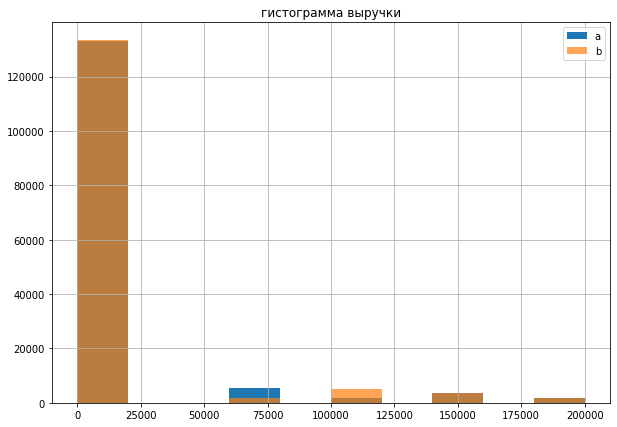

In [10]:
# Визуализируем выручку
plt.figure(figsize=(10,7))
plt.hist(x=df[df['group']=='A']['price'], label='a')
plt.hist(x=df[df['group']=='B']['price'], label='b',alpha= 0.7)
plt.title('гистограмма выручки')
plt.legend()
plt.grid(True)
plt.show()

### Анализ куммулятивной таблицы

Напишем функцию, которая для каждой уникальной даты в столбце date отфильтрует строки таблицы, где значения даты меньше или равны этой уникальной дате, и посчитает количество пользователей, количество заказов, выручку .

In [11]:
# Сгруппируем таблицу по группе и посчитаем показатели конверсии и среднего чека по каждой группе 
df_pivot_date = df.groupby(['date','group']).agg({'user_id':'count','purchase':'sum','price':'sum'}).reset_index()
df_pivot_date['conversion'] = df_pivot_date['purchase'] / df_pivot_date['user_id'] 
df_pivot_date['avg_check'] = df_pivot_date['price'] / df_pivot_date['purchase']

In [12]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['date'].values: # Запускаем цикл по каждому отдельному значению даты
        out = data[data['date'] <= i].groupby('group').agg({'date':'max', 'user_id':'sum', 'purchase':'sum','price':'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат
df_a = df_pivot_date[df_pivot_date['group'] == 'A']
df_b = df_pivot_date[df_pivot_date['group'] == 'B']
cumm_a = cummulative_table(df_a)
cumm_b = cummulative_table(df_b)
# Рассчитаем куммулятивные показатели конверсии и среднего чека по дням
cumm_a['conversion'] = cumm_a['purchase'] / cumm_a['user_id'] 
cumm_a['avg_check'] = cumm_a['price'] / cumm_a['purchase']
cumm_b['conversion'] = cumm_b['purchase'] / cumm_b['user_id'] 
cumm_b['avg_check'] = cumm_b['price'] / cumm_b['purchase']


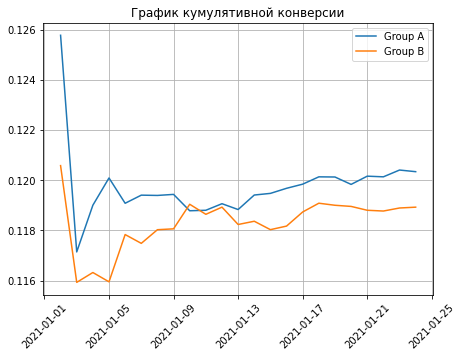

In [13]:
# Построим график конверсии
plt.figure(figsize=(7,5))
plt.plot(cumm_a['date'], cumm_a['conversion'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['conversion'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

Изначально конверсия группы B была ниже конверсии группы А, однако она показывала стабильный рост, и примерно 10 января конверсия группы B стала выше конверсии группы А. После чего конверсия группы B зафиксировалась примерно на этом уровне (с колебаниями). В то время как конверсия группы А начала постепенно расти. В результате конверсия группы А стабильно выше группы B. 

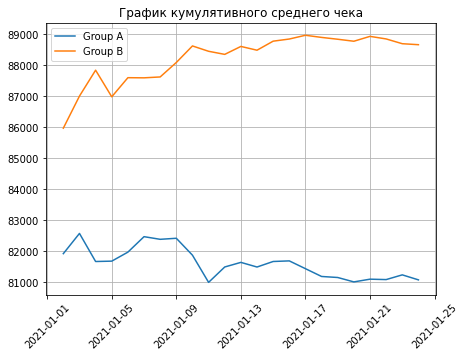

In [14]:
# Построим график изменения срднего чека
plt.figure(figsize=(7,5))
plt.plot(cumm_a['date'], cumm_a['avg_check'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['avg_check'], label='Group B')
plt.title('График кумулятивного среднего чека')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

Средний чек группы В сразу показал рост, средний чек группы А изначально ниже чем группы В. Примерно 10 января у группы А был скачок вниз, далее так и зафиксировался примерно на этом уровне.

### Статистическая проверка гипотез:
-  равенство конверсий;
-  равенство выручки;
-  равенство средних чеков по дням.

**Проверяем распределение показателей конверсии в группах**

Гипотезы:
- Н0: Конверсии обеих групп равны
- Н1: Конверсии обеих групп не равны

<AxesSubplot:>

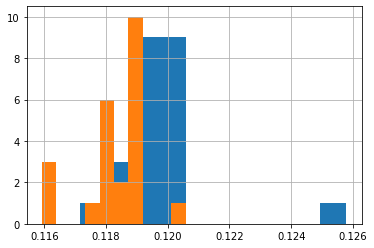

In [15]:
# Построим гистограмму конверсий в группах
cumm_a['conversion'].hist()
cumm_b['conversion'].hist()

Распределение похоже на нормальное , применим Z-test.

In [16]:
# Задаём желаемый уровень статистической значимости: 
a = .05
x_A = df['purchase'][df['group'] == 'A'].sum()
x_B = df['purchase'][df['group'] == 'B'].sum()
n_A = df['user_id'][df['group'] == 'A'].count()
n_B = df['user_id'][df['group'] == 'B'].count()
p_A = x_A / n_A
p_B = x_B / n_B
p = (x_A + x_B) / (n_A + n_B)
# Посчитаем разницу в пропорциях: 
diff = p_A - p_B
# Рассчитаем Z-статистику:
z = diff / mth.sqrt(p * (1 - p) * (1/n_A + 1/n_B))
# Зададим нормальное стандартное распределение со средним, равным нулю, и стандартным отклонением, равным единице:
distr = st.norm(0, 1)
# Рассчитаем p-value:
z_p_val = (1 - distr.cdf(abs(z))) * 2
print('P-value равен', z_p_val)

P-value равен 0.23940749849829834


P-value больше принятого уровня значимости, следовательно, статистически значимая разница между конверсиями отсутствует.

## Проверяем различия в стоимости заказов между группами

Проверим гипотезы:
- Н0: Стоимости заказов групп равны
- Н1: Стоимости заказов групп не равны

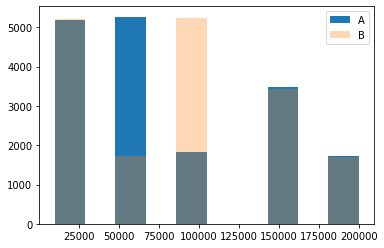

In [17]:
plt.hist(df[(df['group'] == 'A') & (df['purchase'] == 1)]['price'], label='A')
plt.hist(df[(df['group'] == 'B') & (df['purchase'] == 1)]['price'], label='B', alpha=0.3)
plt.legend() 
plt.show() 

Распределение не похоже на нормальное, для проверки гипотез будем использовать тест Манна-Уитни.

In [18]:
# Запишем стоимость заказов в отдельную переменную
gr_a = df[(df['group'] == 'A') & (df['purchase'] == 1)]['price']
gr_b = df[(df['group'] == 'B') & (df['purchase'] == 1)]['price']
# Зададим уровень значимости и применим тест Манна-Уитни
alpha = .05
results = st.mannwhitneyu(gr_a, gr_b)
print('p-value', results.pvalue/2)
if (results.pvalue/2 < alpha):
   print("Отвергаем нулевую гипотезы - стоимости заказов не равны")
else:
   print("Не отвергаем нулевую гипотезу - стоимости заказов обеих групп равны")

p-value 1.412680672643368e-37
Отвергаем нулевую гипотезы - стоимости заказов не равны


## Проверяем различия в средних чеках между группами

Проверим гипотезы:
- Н0: Средние чеки обеих групп равны
- Н1: Средние чеки обеих групп не равны

<AxesSubplot:>

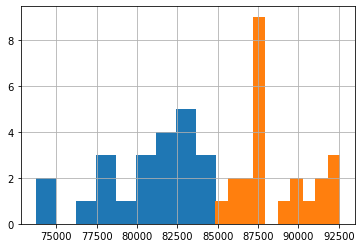

In [19]:
# Построим гистограмму среднего чека в группах
df_pivot_date['avg_check'][df_pivot_date['group'] == 'A'].hist()
df_pivot_date['avg_check'][df_pivot_date['group'] == 'B'].hist()

Распределение похоже на нормальное, используем t-test.

In [20]:
# Задаём желаемый уровень статистической значимости: 
alpha = .05
# Запишем средние чеки в отдельную переменную
avg_a = df_pivot_date['avg_check'][df_pivot_date['group'] == 'A']
avg_b = df_pivot_date['avg_check'][df_pivot_date['group'] == 'B']
# Запускаем метод, чтобы получить p-value, которое будем сравнивать с alpha
results = st.ttest_ind(avg_a, avg_b, equal_var = True)
print(results)
if (results.pvalue < alpha):
   print("Отвергаем нулевую гипотезы - стоимости заказов не равны")
else:
   print("Не отвергаем нулевую гипотезу - стоимости заказов обеих групп равны")

Ttest_indResult(statistic=-9.609061044565284, pvalue=2.2523589349617907e-12)
Отвергаем нулевую гипотезы - стоимости заказов не равны


## Вывод

Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. Зато средний чек группы B значительно выше среднего чека группы A. Статистическая значимость достигнута. Вариант сайта B приносит значимо больше выручки, чем вариант сайта A. Рекомендуем признать, что вариант B лучше, чем вариант A